In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
from keras.preprocessing.image import img_to_array,load_img,ImageDataGenerator
from keras.layers import Dense ,Input, Dropout, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import load_model, Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


# Declaration of Images sizes

In [2]:
pic_size=48
folder_path=os.path.join(os.getcwd(), 'images/')

# Training and validating

In [3]:
batch_size=128


# Let's use some data augmentaiton
datagen_train= ImageDataGenerator(rescale = 1.0/255.0,
                                  width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   rotation_range = 20,
                                   horizontal_flip = True)
datagen_val = ImageDataGenerator(rescale= 1.0/255)

train_set = datagen_train.flow_from_directory(folder_path+'train',target_size=(pic_size,pic_size),color_mode='grayscale',
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True)

test_set= datagen_val.flow_from_directory(folder_path+'validation',
                                            target_size=(pic_size,pic_size),
                                            color_mode='grayscale',
                                            batch_size=batch_size,
                                            class_mode='categorical',
                                            shuffle=False)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


# Model of 4 convolutions and 2 dense layers

In [4]:
no_of_classes=7
model=Sequential()

#1st CNN Layer
model.add(Conv2D(64,(3,3),padding='same', input_shape=(48,48,1)) )
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#2nd CNN Layer
model.add(Conv2D(128,(5,5),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(.25))

#3rd CNN Layer
model.add(Conv2D(512,(3,3), padding=('same')))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#4th CNN Layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

#fully connected 1st Layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

#Fully connected 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(no_of_classes, activation='softmax'))


opt=Adam(lr=.0001)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

2022-10-04 21:51:09.631584: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-04 21:51:09.632043: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 128)      

# Model Fitting

In [7]:

# number of epochs to train the NN
epochs = 100

# checkpoint to save best model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint=ModelCheckpoint(filepath='./modelbestweights.h5', mode='max', monitor='val_accuracy', verbose=1, save_best_only=True)

early_stopping = EarlyStopping(monitor='val_accuracy',
                          min_delta=0,
                          patience=5,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]


model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=.001),metrics=['accuracy'])

In [8]:
history=model.fit_generator(train_set,
                           steps_per_epoch=train_set.n//train_set.batch_size,
                           epochs=epochs,
                           validation_data=test_set,
                           validation_steps=test_set.n//test_set.batch_size,
                           callbacks=callbacks_list)

Epoch 1/100
225/225 [==============================] - 2003s 9s/step - loss: 0.9902 - accuracy: 0.6232 - val_loss: 1.4410 - val_accuracy: 0.5868

Epoch 00001: val_accuracy improved from -inf to 0.58679, saving model to ./modelbestweights.h5
Epoch 2/100
225/225 [==============================] - 2273s 10s/step - loss: 0.9782 - accuracy: 0.6279 - val_loss: 0.9165 - val_accuracy: 0.5536

Epoch 00002: val_accuracy did not improve from 0.58679
Epoch 3/100
225/225 [==============================] - 1760s 8s/step - loss: 0.9757 - accuracy: 0.6329 - val_loss: 0.9021 - val_accuracy: 0.6078

Epoch 00003: val_accuracy improved from 0.58679 to 0.60781, saving model to ./modelbestweights.h5
Epoch 4/100
225/225 [==============================] - 1901s 8s/step - loss: 0.9675 - accuracy: 0.6349 - val_loss: 1.0580 - val_accuracy: 0.6134

Epoch 00004: val_accuracy improved from 0.60781 to 0.61343, saving model to ./modelbestweights.h5
Epoch 5/100
225/225 [==============================] - 1742s 8s/step 

# Plot accuracy

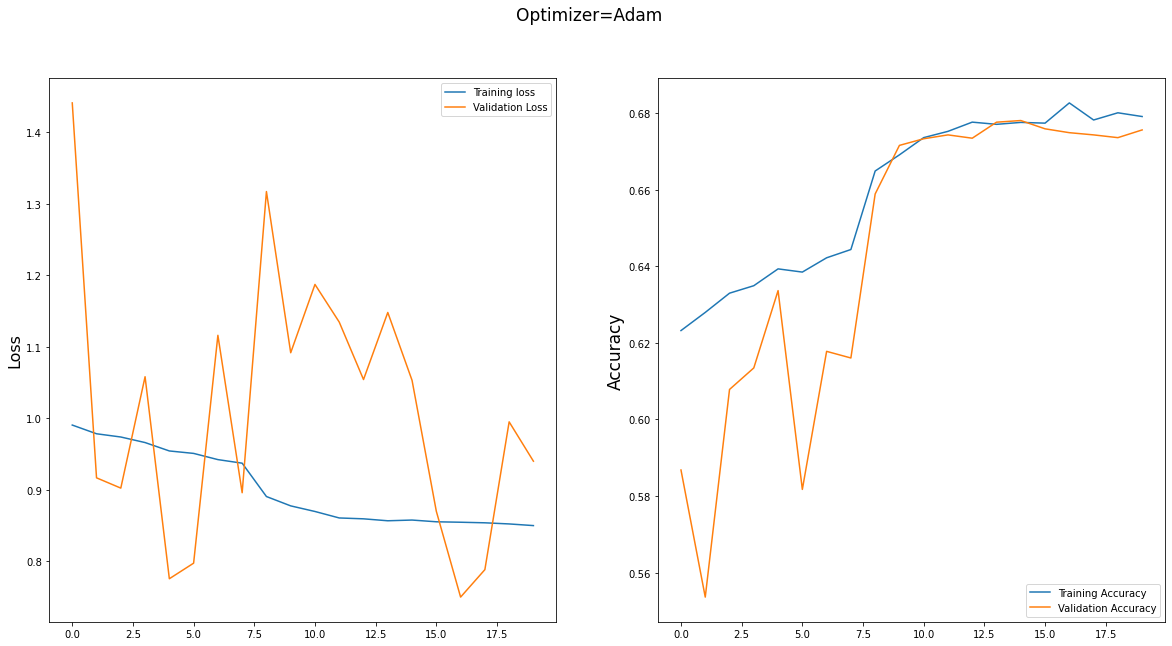

In [9]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.suptitle('Optimizer=Adam', fontsize=17)
plt.ylabel('Loss',fontsize=16)
plt.plot(history.history['loss'],label='Training loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.ylabel('Accuracy', fontsize=17)
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

Model has best validation accuracy score 67.8%